# Кластеризация моделей

Мне удалось собрать $2138$ моделей и получить для них дескрипторы.

Для экспериментов были выбраны следующие 2 алгоритма кластеризации: 

- Алгоритм **KMeans**, так как он является одним из самых популярных и эффективных алгоритмов на практике. Достоинство **KMeans** -- возможность указать количество кластеров как один из гиперпараметров модели. Алгоритм чувствителен к масштабу признаков, поэтому перед его применением следует сделать нормализацию. Для **KMeans** были проведены эксперименты с **PCA** для понижения размерности пространства

- **Агломеративная кластеризация**, которая также позволяет выбрать необходимое количество кластеров и метрику расстояния между объектами, что важно. На паре был **"Аналитический подход к сравнению 3D моделей"**, появилось желание исследовать его на практике

Если известно распределение по классам, то существуют внешние метрики кластеризации. Например, я решил использовать одну из самых популярных метрик внешней кластеризации **Rand index**. С другой стороны, хочется так же оценивать структуру кластеров, в качестве внутренней метрики качества был выбран **индекс Дэвиcа-Болдуина**. Я также решил смотреть на распределение классов моделей по кластерам. 

Для итоговой модели я выбрал всевозможные типы гистограмм (8 типов), однако для каждого типа взял дескриптор, состоящией из 64 числа. Итоговый размер вектора-признаков будет равен $8 \times 64 = 512$, при $2138$ доступных дескрипторах этого должно быть достаточно, невысокий риск переобучения или сильного влияния шума. Я так же пробовал выбирать другое количество значений гистограмм, это не дало существенного улучшения качества, поэтому я выбрал использовать гистограммы из 64 чисел.

Хорошей практикой в **ML** является разделение выборки на **train**, **val** и **test** для предотвращения переобучения. Однако, проводя эксперименты, я обнаружил, что нет такой кластеризации, которая давала бы приемлемый результат. Поэтому я решил отказаться от разбиения и выборки на 3 части, а просто найти наиболее подходящий алгоритм и параметры для него. 

Для того, чтобы наши эксперименты были воспроизводимы, зафиксируем **random_seed**.

In [1]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import rand_score, davies_bouldin_score
from typing import Dict, Set, List, Any, Tuple, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
data_dir = "./data/"
histograms_dir = data_dir + "histograms"
labels_path = data_dir + "labels.csv"

In [3]:
h_types = ["model_bounding_sphere_strict_outer",
           "model_bounding_sphere_strict_outer_absolute",
           "model_bounding_sphere_missed",
           "model_bounding_sphere_concentric_sphere",
           "hull_bounding_sphere_strict_outer",
           "hull_bounding_sphere_strict_outer_absolute",
           "hull_bounding_sphere_missed",
           "hull_bounding_sphere_concentric_sphere"]

bins = 64
random_state = 42

## Подготовка данных

In [4]:
def load_json(file_path: str) -> Dict[str, Any]: 
    with open(file_path, "r") as file: 
        return json.load(file)

In [5]:
labels_df = pd.read_csv(labels_path)
models = labels_df.model.tolist()

Загрузим все дескрипторы. 

In [6]:
X = []
for model in tqdm(models): 
    x_item = [] 
    hist_path = os.path.join(histograms_dir, f"{model}.json")
    hist_dict = load_json(hist_path)
    hist_data = hist_dict["histogram_data"]
    
    for h_type in h_types: 
        for entry in hist_data: 
            if entry["type"] == h_type and entry["intervals"] == bins: 
                x_item.extend(entry["data"])
                break 
                
    X.append(x_item)

100%|██████████| 2137/2137 [00:02<00:00, 943.49it/s] 


Загрузим **labels** и перекодируем их. 

In [7]:
y_true = labels_df.type.tolist()
label_encoder= LabelEncoder().fit(y_true)
y_true = label_encoder.transform(y_true)
n_classes = len(label_encoder.classes_)

In [8]:
X = np.array(X)
y_true = np.array(y_true)
print(f"Количество моделей: {X.shape[0]}")
print(f"Размер признакового пространства: {X.shape[1]}")
print(f"Количество классов: {n_classes}")

Количество моделей: 2137
Размер признакового пространства: 512
Количество классов: 5


Посмотрим, что набор данных сбалансированный, распределение по классам близко к равномерному. 

In [9]:
def print_distributions(y: np.ndarray):
    print(f"{'Type' :<8} | Samples")
    for model_type, counts in zip(*np.unique(y, return_counts=True)): 
        print(f"{label_encoder.classes_[model_type]:<8} | {counts}")

In [10]:
print_distributions(y_true)

Type     | Samples
Cone     | 424
Cube     | 394
Cylinder | 414
Sphere   | 477
Torus    | 428


## Исследование данных

Попробуем сначала отобразить данные на двумерной плоскости с помощью алгоритмов **PCA** и **t-SNE**.

In [11]:
X_pca = PCA(n_components=2, random_state=random_state).fit_transform(X)
X_tsne = TSNE(n_components=2, random_state=random_state).fit_transform(X)

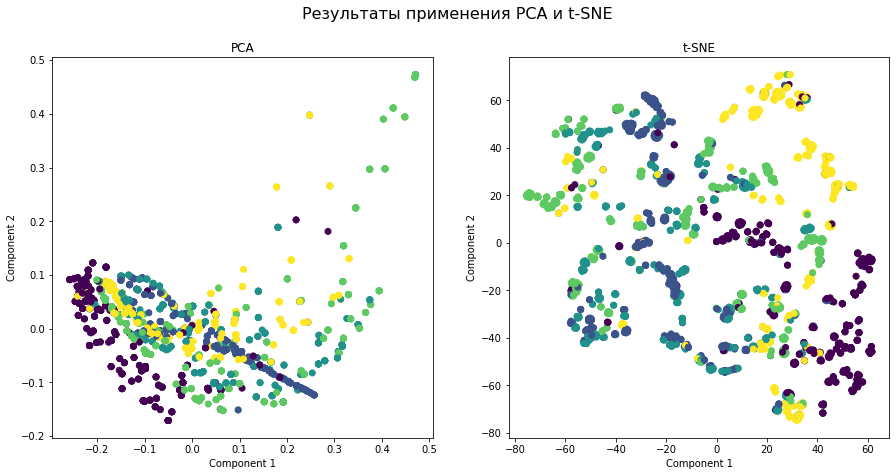

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
colors = [int(y % n_classes) for y in y_true]

fig.suptitle("Результаты применения PCA и t-SNE", fontsize=16)
ax1.set_title("PCA")
ax2.set_title("t-SNE")

for ax, data in zip([ax1, ax2], [X_pca, X_tsne]): 
    ax.scatter(data[:, 0], data[:, 1], c=colors)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    
plt.show()

Как можно видеть, кластеры слабо различимы, поэтому придется сложно. 

## Кластеризация

### KMeans

Сделаем кластеризацию с помощью **KMeans**, а также попробуем исследовать применимость **PCA**. Метрики качества приведены в начале ноутбука. 

In [13]:
n_components_values = [1, 5, 25, 50, 100, 150, 250, None]

In [14]:
for n_components in n_components_values: 
    X_transformed = PCA(n_components=n_components, random_state=random_state).fit_transform(X)
    X_transformed_scaled = StandardScaler().fit_transform(X_transformed)
    y_pred = KMeans(n_clusters=n_classes, random_state=random_state).fit_predict(X_transformed_scaled)
    
    print(f"Количество компонент: {n_components if n_components else X.shape[1]}")
    print(f"Rand score: {rand_score(y_true, y_pred):.3f}")
    print(f"Индекс Дэвиcа-Болдуина: {davies_bouldin_score(X_transformed_scaled, y_pred):.3f}")
    print()

Количество компонент: 1
Rand score: 0.689
Индекс Дэвиcа-Болдуина: 0.497

Количество компонент: 5
Rand score: 0.661
Индекс Дэвиcа-Болдуина: 1.158

Количество компонент: 25
Rand score: 0.670
Индекс Дэвиcа-Болдуина: 3.190

Количество компонент: 50
Rand score: 0.508
Индекс Дэвиcа-Болдуина: 3.529

Количество компонент: 100
Rand score: 0.515
Индекс Дэвиcа-Болдуина: 5.322

Количество компонент: 150
Rand score: 0.390
Индекс Дэвиcа-Болдуина: 5.039

Количество компонент: 250
Rand score: 0.304
Индекс Дэвиcа-Болдуина: 4.594

Количество компонент: 512
Rand score: 0.369
Индекс Дэвиcа-Болдуина: 7.791



Выберем **25** компонент (высокий **Rand score** и приемлемый **Индекс Дэвиса-Болдуина**) и посмотрим на распределение классов по кластерам. 

In [15]:
X_transformed = PCA(n_components=25, random_state=random_state).fit_transform(X)
X_transformed_scaled = StandardScaler().fit_transform(X_transformed)
y_pred = KMeans(n_clusters=n_classes, random_state=random_state).fit_predict(X_transformed_scaled)

for cluster in range(n_classes):
    print(f"Кластер {cluster + 1}")
    print_distributions(y_true[y_pred == cluster]) 
    print()

Кластер 1
Type     | Samples
Cone     | 82
Cube     | 324
Cylinder | 302
Sphere   | 232
Torus    | 56

Кластер 2
Type     | Samples
Cone     | 9
Cube     | 6
Cylinder | 3
Sphere   | 9
Torus    | 233

Кластер 3
Type     | Samples
Cone     | 181
Cube     | 7
Cylinder | 21
Sphere   | 145
Torus    | 28

Кластер 4
Type     | Samples
Cone     | 1
Sphere   | 22
Torus    | 7

Кластер 5
Type     | Samples
Cone     | 151
Cube     | 57
Cylinder | 88
Sphere   | 69
Torus    | 104



**Выводы**: 

- В **кластере 1** почти равномерное распределение, есть 3 доминирующих класса, остальные представлены в меньшем масштабе

- В **кластере 2** преимущественно сконцентрированы **Torus**, они хорошо отделяются от других 

- В **кластере 3** преобладают **Cone** и **Sphere** 

- В **кластере 4** немного объектов, однако он почти полностью состоит из **Sphere** 

- В **кластере 5** (как и в **кластере 1**) много разных классов, но преобладают **Cone** и **Torus**

### Agglomerative Clustering

Применим **Агломеративную кластеризацию**, используя расстояние между гистограммами с пары

In [16]:
def distance(hist1: np.ndarray, hist2: np.ndarray) -> float: 
    """
    Расстояние между гистограммами одного типа. 
    """
    
    s1 = 0.5 * np.abs(hist1 - hist2).sum() / (hist1.sum() + hist2.sum())
    s2 = np.sqrt(np.sum((hist1 - hist2) ** 2) / (np.sum(hist1 ** 2) + np.sum(hist2 ** 2)))
    return s1 + s2

def custom_distance(x1: np.ndarray, x2: np.ndarray, c: Optional[np.ndarray] = None) -> float:
    """
    Расстояние между двумя объектами. 
    """
    n_histograms = len(h_types)
    
    if c is None: 
        c = np.full(n_histograms, 1 / n_histograms) # Равномерное распределение 
        
    feature_dim = len(x1)    
    distances = []
    for i in range(0, feature_dim, bins): 
        hist1, hist2 = x1[i:(i + bins)], x2[i:(i + bins)]
        distances.append(distance(hist1, hist2))
        
    distances = np.array(distances)
    return distances @ c

In [17]:
n_samples = len(X)
distance_matrix = np.zeros((n_samples, n_samples))

for i in tqdm(range(n_samples)): 
    for j in range(i, n_samples): 
        distance_matrix[i, j] = distance_matrix[j, i] = custom_distance(X[i], X[j])

100%|██████████| 2137/2137 [08:02<00:00,  4.43it/s] 


In [18]:
y_pred = AgglomerativeClustering(n_clusters=n_classes, 
                                 affinity="precomputed", 
                                 linkage="average").fit_predict(distance_matrix)

print(f"Rand score: {rand_score(y_true, y_pred):.3f}")
print(f"Индекс Дэвиcа-Болдуина: {davies_bouldin_score(X, y_pred):.3f}")
print()

for cluster in range(n_classes):
    print(f"Кластер {cluster + 1}")
    print_distributions(y_true[y_pred == cluster]) 
    print()

Rand score: 0.529
Индекс Дэвиcа-Болдуина: 1.010

Кластер 1
Type     | Samples
Cone     | 3
Cube     | 1
Cylinder | 5
Sphere   | 36
Torus    | 15

Кластер 2
Type     | Samples
Cone     | 248
Cube     | 253
Cylinder | 288
Sphere   | 277
Torus    | 321

Кластер 3
Type     | Samples
Cone     | 10
Cube     | 132
Cylinder | 105
Sphere   | 128
Torus    | 40

Кластер 4
Type     | Samples
Cone     | 163
Cube     | 8
Cylinder | 16
Sphere   | 19
Torus    | 51

Кластер 5
Type     | Samples
Sphere   | 17
Torus    | 1



**Выводы**: 

- В **кластере 2**, **кластере 3** распределения, близкое к равномерному 

- В **кластере 1**, **кластере 4**, **кластере 5** есть доминирующие классы, однако кластеры по размеру слишком разные 

Таким образом, удалось выявить некоторые закономерности в данных, но найти такое разбиение на кластеры, чтобы все классы распределилсь по разным кластерам, мне не удалось. Требуются дальнейшие исследования и эксперименты. **KMeans** проявил себя немного лучше, чем **Agglomerative Clustering** с метрикой расстояния с пары. 